In [ ]:
# # !pip install --upgrade tensorflow
# !pip install tensorflow==2.15
# # !pip install --upgrade tensorflow
# !pip install -U tf_keras # Keras 2
# import os
# os.environ["TF_USE_LEGACY_KERAS"] = "1"
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# !pip install transformers datasets tensorflow

In [ ]:
!pip install datasets
!pip install transformers[torch]
!pip install evaluate
!pip install peft
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 7.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x8

In [ ]:
import os
import tensorflow as tf
from transformers import TFElectraForSequenceClassification, ElectraTokenizer
from datasets import load_dataset, load_metric
from google.colab import drive

In [ ]:
from datasets import load_dataset, load_metric
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
)
from peft import get_peft_config, PeftModel, PeftConfig, get_peft_model, LoraConfig, TaskType
import evaluate
import torch
import numpy as np

In [ ]:
torch.backends.cuda.matmul.allow_tf32 = False

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Weights locations



In [ ]:
# update as needed
checkpoint_dir = '/content/drive/My Drive/W266_Final_Project/Gray/electra-base-qnli-final_6epochs_LoRA_rank32_quant_fl16'

In [ ]:
# LoRA hyperparameters
# r = 32
# lora_alpha = 32
# lora_dropout = 0.1

In [ ]:
# Load ELECTRA BASE model and tokenizer
model_checkpoint = "google/electra-base-discriminator"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

id2label = {
    0: "neg",
    1: "pos"
}

label2id = {
    "neg": 0,
    "pos": 1
}

model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=2, id2label=id2label, label2id=label2id
)
for name, param in model.named_parameters():
    param.requires_grad = False

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.load_adapter(checkpoint_dir)
model

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): lora.Linear(
                (base_layer): Linear(in_features=768, out_features=768, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=768, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (defau

In [ ]:
print(type(model))

<class 'transformers.models.electra.modeling_electra.ElectraForSequenceClassification'>


In [ ]:
_= model.to("cuda")

In [ ]:
# Load and preprocess the GLUE QNLI dataset
# https://huggingface.co/docs/datasets/v1.1.2/loading_datasets.html
# https://huggingface.co/docs/datasets/en/process
# https://huggingface.co/datasets/nyu-mll/glue
dataset = load_dataset("glue", "qnli")
metric = load_metric("glue", "qnli")

encoded_dataset = dataset.map(lambda examples: tokenizer(examples["question"],
                                                         examples["sentence"],
                                                         truncation=True,
                                                         padding="max_length",
                                                         return_tensors="tf"),
                              batched=True)

Generating train split:   0%|          | 0/104743 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5463 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5463 [00:00<?, ? examples/s]

<ipython-input-14-86000d1cd3d5>:6: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("glue", "qnli")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for glue contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/glue/glue.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


Map:   0%|          | 0/104743 [00:00<?, ? examples/s]

Map:   0%|          | 0/5463 [00:00<?, ? examples/s]

Map:   0%|          | 0/5463 [00:00<?, ? examples/s]

In [ ]:
encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 104743
    })
    validation: Dataset({
        features: ['question', 'sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5463
    })
    test: Dataset({
        features: ['question', 'sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5463
    })
})

In [ ]:
# trainer object
trainer_preds = Trainer(model=model)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
# get the two columns prediction array
predictions = trainer_preds.predict(encoded_dataset["validation"])
predictions.predictions.shape

(5463, 2)

In [ ]:
predictions.predictions

array([[ 2.0299735 , -2.0595875 ],
       [-0.6668953 ,  0.5365513 ],
       [ 0.03202544, -0.06632612],
       ...,
       [-2.0294008 ,  1.892079  ],
       [-2.6517668 ,  2.5663433 ],
       [-2.9823847 ,  2.9999335 ]], dtype=float32)

In [ ]:
positive_class_logits = predictions.predictions[:, 1]
positive_class_logits

array([-2.0595875 ,  0.5365513 , -0.06632612, ...,  1.892079  ,
        2.5663433 ,  2.9999335 ], dtype=float32)

In [ ]:
# pos_probs = tf.nn.softmax(predictions, axis=-1)[:, 1].numpy()
pos_probs = tf.nn.softmax(predictions.predictions, axis=1)[:, 1].numpy()
pos_probs

array([0.01647075, 0.7691373 , 0.47543192, ..., 0.9805731 , 0.9946116 ,
       0.99748343], dtype=float32)

In [ ]:
len(pos_probs)

5463

In [ ]:
predicted_labels = np.argmax(predictions.predictions, axis=1)
predicted_labels

array([0, 1, 0, ..., 1, 1, 1])

In [ ]:
true_labels = [example['label'] for example in dataset['validation']]
# true_labels

# Analysis

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, accuracy_score, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

## Performance Evaluation

### Confusion Matrix

[[2500  202]
 [ 209 2552]]


<Axes: >

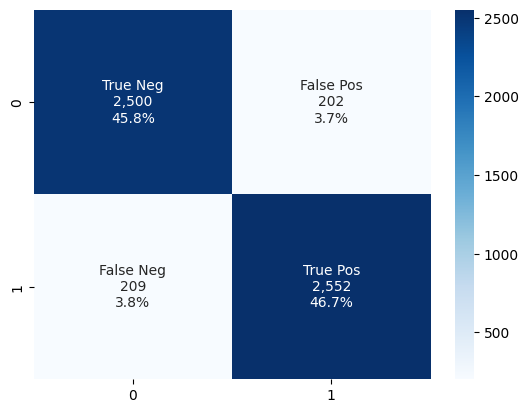

In [ ]:
# https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea

Confusion_Matrix = confusion_matrix(true_labels, predicted_labels)
print(Confusion_Matrix)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{:,}".format(value) for value in Confusion_Matrix.flatten()]
group_percentages = ["{0:.1%}".format(value) for value in Confusion_Matrix.flatten()/np.sum(Confusion_Matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(Confusion_Matrix, annot=labels, fmt='', cmap='Blues')



---



### F1 Score, Precision, and Recall

In [ ]:
F1_Score = f1_score(true_labels, predicted_labels)
Precision = precision_score(true_labels, predicted_labels)
Recall = recall_score(true_labels, predicted_labels)

accuracy = accuracy_score(true_labels, predicted_labels)

tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()
specificity = tn / (tn + fp)

print("F1 Score:\t", round(F1_Score, 4))
print("Precision:\t", round(Precision, 4))
print("Recall:\t\t", round(Recall, 4))
print("Accuracy:\t", round(accuracy, 4))
print("Specificity:\t", round(specificity, 4))



F1 Score:	 0.9255
Precision:	 0.9267
Recall:		 0.9243
Accuracy:	 0.9248
Specificity:	 0.9252




---



## Error Analysis
- https://dataheroes.ai/blog/improving-machine-learning-models-a-guide-to-error-classification-analysis/
- Per Huggingface guidelines: 0 = Entailment, 1 = Not Entailment

### Error Categorization

In [ ]:
NUM_PRED_ERRORS = 30

error_indices = []
for i in range(len(predicted_labels)):
    if predicted_labels[i] != true_labels[i]:
        error_indices.append(i)

sample_error_indices = np.random.choice(error_indices, size=NUM_PRED_ERRORS, replace=False)

In [ ]:
print("Predicted Labels:\t", "{:,}".format(len(predicted_labels)))
print("True Labels:\t\t", "{:,}".format(len(true_labels)))
print("Error Indices:\t\t", "{:,}".format(len(error_indices)))

Predicted Labels:	 5,463
True Labels:		 5,463
Error Indices:		 411


#### Question Types Struggles

In [ ]:
len(dataset['validation']['question'])

5463

In [ ]:
dataset['validation']['question'][:10]

['What came into force after the new constitution was herald?',
 'What is the first major city in the stream of the Rhine?',
 'What is the minimum required if you want to teach in Canada?',
 "How was Temüjin kept imprisoned by the Tayichi'ud?",
 'What did Herr Gott, dich loben wir become known as ?',
 'What year did the the case go before the supreme court?',
 'What does UMC stand for?',
 'What is the name of the professional skateboarder that lives in southern California?',
 "Where did Temüjin hide during his escape from the Tayichi'ud?",
 'What are the most active parts of ctenophora?']

In [ ]:
# First word of each question
first_word = []
word_counts = []
for question in dataset['validation']['question']:
    words = question.split()[:1]
    first_word.append(words)
    first_word.sort()
    word_count = len(question.split())
    word_counts.append(word_count)


# Questions with incorrectly predicted answers
incorrect_predictions = []
for i in range(len(predicted_labels)):
    if predicted_labels[i] != true_labels[i]:
        incorrect_predictions.append(i)

# First word of all the incorrect predictions
incorrect_predictions_first_word = []
for i in incorrect_predictions:
    incorrect_predictions_first_word.append(first_word[i])

In [ ]:
len(incorrect_predictions_first_word)

411

In [ ]:
first_word_df = pd.DataFrame(incorrect_predictions_first_word, columns=["First_Word"])
first_word_df = first_word_df.groupby(["First_Word"]).size().sort_values(ascending=False).head(10)
error_types = pd.DataFrame(first_word_df, columns=["Error Count"])
error_types

,Error Count
First_Word,
What,180
How,60
Who,35
When,32
Where,19
Which,17
The,10
In,9
Why,6


In [ ]:
error_types["Pct of Total Errors"] = round(error_types["Error Count"] / len(dataset['validation']['question']) * 100, 2)
error_types["Pct of Total Errors"] = error_types["Pct of Total Errors"].apply(lambda x: f"{x}%")
error_types

,Error Count,Pct of Total Errors
First_Word,,
What,180,3.29%
How,60,1.1%
Who,35,0.64%
When,32,0.59%
Where,19,0.35%
Which,17,0.31%
The,10,0.18%
In,9,0.16%
Why,6,0.11%


#### Answer Length Struggles

##### Incorrect Predictions

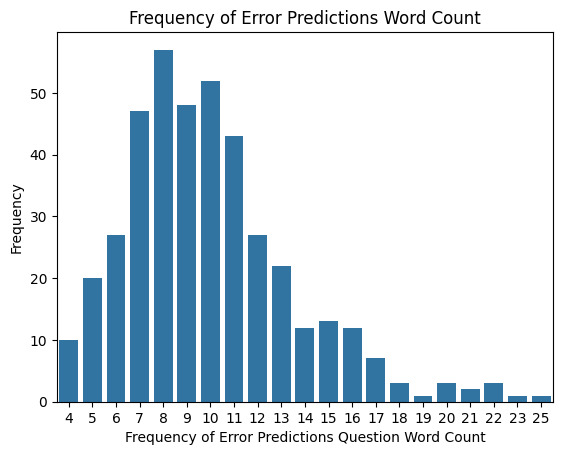

In [ ]:
word_count_freq = []
for i in incorrect_predictions:
    word_count_freq.append(word_counts[i])

word_count_freq_df = pd.DataFrame(word_count_freq, columns=["Error_Predictions_Question_Word_Count"])

word_count_freq_df = word_count_freq_df['Error_Predictions_Question_Word_Count'].value_counts().reset_index()
word_count_freq_df.columns = ['Error_Predictions_Question_Word_Count', 'Frequency']

word_count_freq_df = word_count_freq_df.sort_values(by='Error_Predictions_Question_Word_Count')

sns.barplot(x='Error_Predictions_Question_Word_Count', y='Frequency', data=word_count_freq_df)
plt.xlabel('Frequency of Error Predictions Question Word Count')
plt.ylabel('Frequency')
plt.title('Frequency of Error Predictions Word Count')
plt.show()

##### Correct Predictions

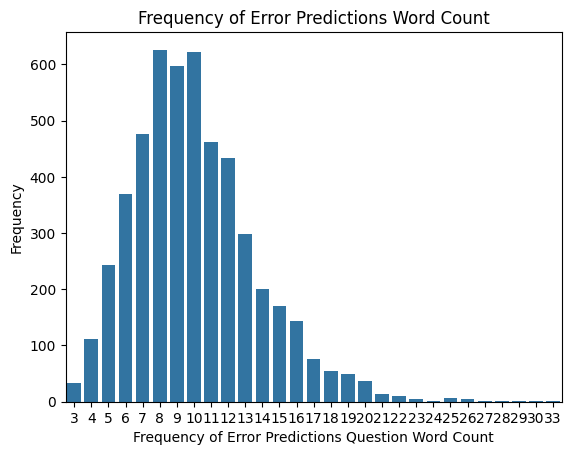

In [ ]:
correct_predictions = []
for i in range(len(predicted_labels)):
    if predicted_labels[i] == true_labels[i]:
        correct_predictions.append(i)

word_count_freq = []
for i in correct_predictions:
    word_count_freq.append(word_counts[i])

word_count_freq_df = pd.DataFrame(word_count_freq, columns=["Error_Predictions_Question_Word_Count"])

word_count_freq_df = word_count_freq_df['Error_Predictions_Question_Word_Count'].value_counts().reset_index()
word_count_freq_df.columns = ['Error_Predictions_Question_Word_Count', 'Frequency']

word_count_freq_df = word_count_freq_df.sort_values(by='Error_Predictions_Question_Word_Count')

sns.barplot(x='Error_Predictions_Question_Word_Count', y='Frequency', data=word_count_freq_df)
plt.xlabel('Frequency of Error Predictions Question Word Count')
plt.ylabel('Frequency')
plt.title('Frequency of Error Predictions Word Count')
plt.show()

#### Manual Error Categorization

In [ ]:
print("Sample Errors:\n\n")

for i in sample_error_indices:
    print(f"Index:\t\t {i}")
    print(f"Question:\t {dataset['validation'][int(i)]['question']}")
    print(f"Answer:\t\t {dataset['validation'][int(i)]['sentence']}")
    print(f"True Label:\t {true_labels[i]}")
    print(f"Predicted Label: {predicted_labels[i]}")
    print("----------------------------------------------------------------------------\n\n")

Sample Errors:


Index:		 2224
Question:	 When was Doctor Who viewing at its highest level?
Answer:		 Its late 1980s performance of three to five million viewers was seen as poor at the time and was, according to the BBC Board of Control, a leading cause of the programme's 1989 suspension.
True Label:	 1
Predicted Label: 0
----------------------------------------------------------------------------


Index:		 430
Question:	 What types of preparation do pharmacists have?
Answer:		 Pharmacists are healthcare professionals with specialised education and training who perform various roles to ensure optimal health outcomes for their patients through the quality use of medicines.
True Label:	 0
Predicted Label: 1
----------------------------------------------------------------------------


Index:		 784
Question:	 Imperialism and colonialism both assert a states dominance over what?
Answer:		 Imperialism and colonialism have been used in order to describe one's superiority, domination and in



---



### Error Rate Analysis
- Error rate for the different categories of questions
- To identify areas where the model struggles
- Error Rate = Number of Errors in a Category / Total Number of Errors
- Categories:
    - Question understanding errors: 23 / 30 = 0.7667
    - Context understanding errors: 4 / 30 = 0.1333
    - Factual errors: 3 / 30 = 0.1000
    - Logical errors: 0 / 30 = 0.0000



---



### Precision-Recall Curve

sklearn.metrics.precision_recall_curve

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html

In [ ]:
precision, recall, thresholds = precision_recall_curve(true_labels, pos_probs)

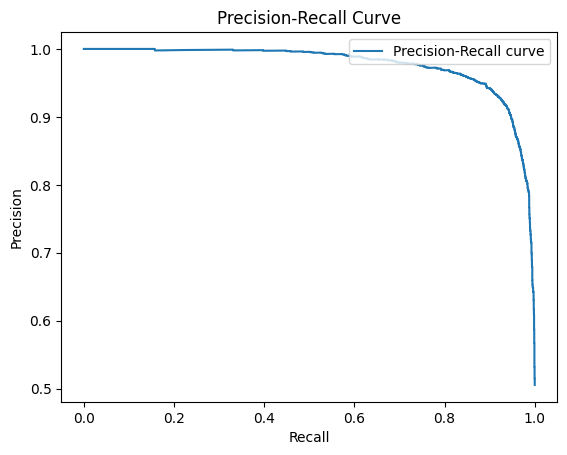

In [ ]:
plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()

In [ ]:
precision

array([0.50539996, 0.50549249, 0.50558506, ..., 1.        , 1.        ,
       1.        ])

In [ ]:
recall

array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
       7.24375226e-04, 3.62187613e-04, 0.00000000e+00])

In [ ]:
thresholds

array([9.1358810e-04, 9.6158206e-04, 9.9533715e-04, ..., 9.9936682e-01,
       9.9937963e-01, 9.9942076e-01], dtype=float32)

In [ ]:
print("precision:", len(precision))
print("recall:", len(recall))
print("thresholds:", len(thresholds))

precision: 5443
recall: 5443
thresholds: 5442


In [ ]:
target_values = [0.90, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]

for target_precision in target_values:
  best_threshold = None

  for i in range(len(thresholds)):
      if precision[i] > target_precision:
          if best_threshold is None or recall[i] > recall[np.where(thresholds == best_threshold)][0]:
              best_threshold = thresholds[i]

  print(f"The best threshold for high precision above {target_precision} is: {best_threshold}")

The best threshold for high precision above 0.9 is: 0.32349681854248047
The best threshold for high precision above 0.91 is: 0.378704309463501
The best threshold for high precision above 0.92 is: 0.44963663816452026
The best threshold for high precision above 0.93 is: 0.5299595594406128
The best threshold for high precision above 0.94 is: 0.6009290814399719
The best threshold for high precision above 0.95 is: 0.713123083114624
The best threshold for high precision above 0.96 is: 0.8012602925300598
The best threshold for high precision above 0.97 is: 0.8890738487243652
The best threshold for high precision above 0.98 is: 0.9548481106758118
The best threshold for high precision above 0.99 is: 0.98309326171875


# Threshold Verification

In [ ]:
# Obtained from previous calculations above
precision_threshold = 0.713123083114624

predicted_labels = [1 if pred_prob > precision_threshold else 0 for pred_prob in pos_probs]

# predicted_labels

In [ ]:
true_labels = [example['label'] for example in dataset['validation']]
# true_labels

### Confusion Matrix

[[2575  127]
 [ 336 2425]]


<Axes: >

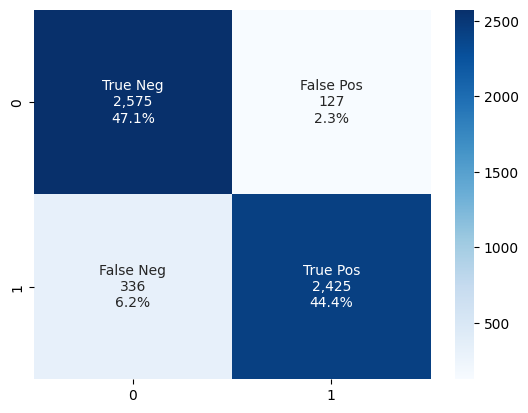

In [ ]:
# https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea

Confusion_Matrix = confusion_matrix(true_labels, predicted_labels)
print(Confusion_Matrix)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{:,}".format(value) for value in Confusion_Matrix.flatten()]
group_percentages = ["{0:.1%}".format(value) for value in Confusion_Matrix.flatten()/np.sum(Confusion_Matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(Confusion_Matrix, annot=labels, fmt='', cmap='Blues')



---



### F1 Score, Precision, and Recall

In [ ]:
F1_Score = f1_score(true_labels, predicted_labels)
Precision = precision_score(true_labels, predicted_labels)
Recall = recall_score(true_labels, predicted_labels)

accuracy = accuracy_score(true_labels, predicted_labels)

tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()
specificity = tn / (tn + fp)

print("F1 Score:\t", round(F1_Score, 4))
print("Precision:\t", round(Precision, 4))
print("Recall:\t\t", round(Recall, 4))
print("Accuracy:\t", round(accuracy, 4))
print("Specificity:\t", round(specificity, 4))



F1 Score:	 0.9129
Precision:	 0.9502
Recall:		 0.8783
Accuracy:	 0.9152
Specificity:	 0.953
